In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Load checkpoint
import pickle
try:
    with open('/content/drive/MyDrive/checkpoint.pkl', 'rb') as f:
        checkpoint = pickle.load(f)
    print("Loaded checkpoint:", checkpoint)
except FileNotFoundError:
    print("No checkpoint found, starting fresh.")


Mounted at /content/drive
No checkpoint found, starting fresh.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abhisheksinghblr/emergency-vehicles-identification")

print("Path to dataset files:", path)

100%|██████████| 30.9M/30.9M [00:00<00:00, 77.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/abhisheksinghblr/emergency-vehicles-identification/versions/1


## Importing the necessary library

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2 # open-cv used for image processing
%matplotlib inline
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
import tensorflow_hub as hub
import keras.utils as image
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
#!pip install opencv-python

## Directory assignment

In [ ]:
train_dir = "/root/.cache/kagglehub/datasets/abhisheksinghblr/emergency-vehicles-identification/versions/1/Emergency_Vehicles/train"
test_dir = "/root/.cache/kagglehub/datasets/abhisheksinghblr/emergency-vehicles-identification/versions/1/Emergency_Vehicles/test"


In [ ]:
image = cv2.imread(r"/root/.cache/kagglehub/datasets/abhisheksinghblr/emergency-vehicles-identification/versions/1/Emergency_Vehicles/train/1.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # converting to RGB

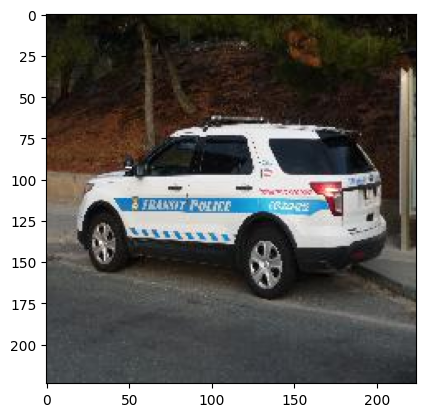

In [ ]:
plt.imshow(image)

In [ ]:
image.shape # This shows the shape of the image (length, width,chanel)

(224, 224, 3)

## Preprocessing

For preprocessing, the ImageDataGenerator is used. It is used for the generation of batches containing the data of tensor images and is
used in the domain of real-time data augmentation.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Keras image data generator is used for the generation

In [ ]:
# Here we are applying our desired transformations
image_gen = ImageDataGenerator(
            rotation_range=20,# specifies the rotation to be 20%
            width_shift_range=0.1, # specifies the width shift of 10%
            height_shift_range=0.1,# specifies the height shift of 10%
            shear_range=0.20, # crops part of the image
            zoom_range=0.20, # #zooms the image by 20%
            fill_mode='nearest', # fills using the nearest pixel
            horizontal_flip=True, # Secifies the horizontal flip
            rescale=1/255 # scales the image
)


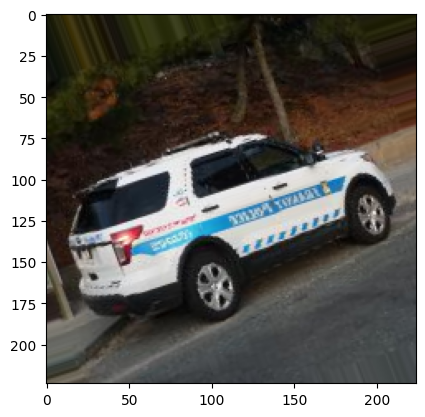

In [ ]:
# showing the transformation
plt.imshow(image_gen.random_transform(image))

In [ ]:
train_df=pd.read_csv("/root/.cache/kagglehub/datasets/abhisheksinghblr/emergency-vehicles-identification/versions/1/Emergency_Vehicles/train.csv")
test_df=pd.read_csv("/root/.cache/kagglehub/datasets/abhisheksinghblr/emergency-vehicles-identification/versions/1/Emergency_Vehicles/test.csv")

In [ ]:
test_df

,image_names
0,1960.jpg
1,668.jpg
2,2082.jpg
3,808.jpg
4,1907.jpg
...,...
701,674.jpg
702,1027.jpg
703,447.jpg
704,2176.jpg


In [ ]:
train_df

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0
...,...,...
1641,1638.jpg,0
1642,1095.jpg,0
1643,1130.jpg,0
1644,1294.jpg,0


In [ ]:
# Check if 'emergency_or_not' column exists before converting its values to string type
if 'emergency_or_not' in train_df.columns:
    train_df['emergency_or_not'] = train_df['emergency_or_not'].astype(str)

if 'emergency_or_not' in test_df.columns:
    test_df['emergency_or_not'] = test_df['emergency_or_not'].astype(str)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       1646 non-null   object
 1   emergency_or_not  1646 non-null   object
dtypes: object(2)
memory usage: 25.8+ KB


In [ ]:
train_generator=image_gen.flow_from_dataframe(dataframe=train_df[:1150], # specify the dataset used for trainin
 directory=train_dir, # specify the path to the directory
 x_col='image_names', # specify the names of the images
 y_col='emergency_or_not', # specifies the class labels
 class_mode='binary', # specifies the kind of classification
 target_size=(224,224), # specifies the dimension to resize the im
 batch_size=50# defines the batch size
 )
validation_generator=image_gen.flow_from_dataframe(dataframe=train_df[1150:], # specify the dataset used for tr
 directory=train_dir, # specify the path to the directory
 x_col='image_names', # specify the names of the images
 y_col='emergency_or_not', # specifies the class labels
 class_mode='binary', # specifies the kind of classification
 target_size=(224,224), # specifies the dimension to resize the im
 batch_size=50 # defines the batch size
 )


Found 1150 validated image filenames belonging to 2 classes.
Found 496 validated image filenames belonging to 2 classes.


## Constructor stage

In [ ]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(224, 224, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compilation stage


In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 110, 110, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │       1,081,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,101,221 (4.20 MB)

 Trainable params: 1,101,157 (4.20 MB)

 Non-trainable params: 64 (256.00 B)

## Training stage

In [ ]:
history=model.fit(train_generator,epochs = 30,validation_data = validation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.5955 - loss: 0.8163 - val_accuracy: 0.7258 - val_loss: 0.6767
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.6817 - loss: 0.5979 - val_accuracy: 0.6290 - val_loss: 0.6678
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.7576 - loss: 0.5245 - val_accuracy: 0.7359 - val_loss: 0.6674
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.7532 - loss: 0.5110 - val_accuracy: 0.6149 - val_loss: 0.6508
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7919 - loss: 0.4533 - val_accuracy: 0.6371 - val_loss: 0.6494
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.7774 - loss: 0.4696 - val_accuracy: 0.6210 - val_loss: 0.6408
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7688 - loss: 0.4449 - val_accuracy: 0.7520 - val_loss: 0.6614
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.8185 - loss: 0.4120 - val_accuracy: 0.7903 - val_loss:

## Evaluation stage

In [ ]:
test_df.index

RangeIndex(start=0, stop=706, step=1)

In [ ]:
test_dir_image = []
for i in tqdm(test_df.index):
    img_path = '/root/.cache/kagglehub/datasets/abhisheksinghblr/emergency-vehicles-identification/versions/1/Emergency_Vehicles/test/' + test_df['image_names'][i]  # Adjust the path to match the directory structure
    img = Image.open(img_path).convert('RGB')  # Load image using PIL
    img = img.resize((224, 224))  # Resize image
    img = np.array(img)  # Convert image to NumPy array
#     img = img / 255.0  # Normalize pixel values
    test_dir_image.append(img)

test = np.array(test_dir_image)


100%|██████████| 706/706 [00:00<00:00, 1049.84it/s]


In [ ]:
pred = model.predict(test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 382ms/step


In [ ]:
num_ = np.floor(pred)

In [ ]:
submission = pd.read_csv('/root/.cache/kagglehub/datasets/abhisheksinghblr/emergency-vehicles-identification/versions/1/Emergency_Vehicles/sample_submission.csv')
submission['emergency_or_not'] = num_

In [ ]:
submission.to_csv('submission29.csv', index = False)

In [ ]:
submission.head(5)

,image_names,emergency_or_not
0,1960.jpg,1.0
1,668.jpg,1.0
2,2082.jpg,0.0
3,808.jpg,1.0
4,1907.jpg,1.0


In [ ]:
#save model
from tensorflow.keras.models import load_model
model.save('vehicle.h5')
model_vechile = load_model(('vehicle.h5'),custom_objects={'KerasLayer':hub.KerasLayer})

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Prediction for /content/images-2.jpeg: Emergency Vehicle


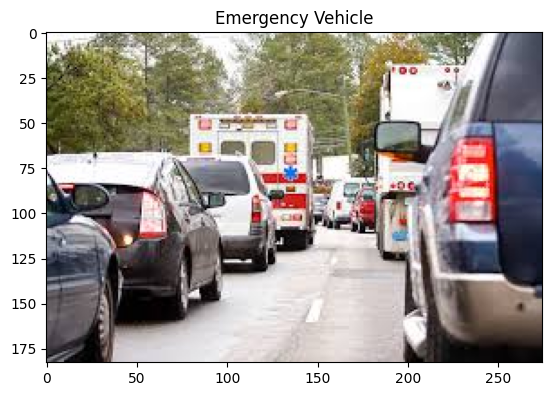

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the trained model (assuming 'vehicle.h5' is in the current directory)
model_vechile = load_model('vehicle.h5')

def predict_emergency_vehicle(image_path):
  """
  Predicts whether an image contains an emergency vehicle.

  Args:
    image_path: The path to the image file.

  Returns:
    A string indicating whether an emergency vehicle is present ("Emergency Vehicle" or "Not an Emergency Vehicle").
  """
  try:
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make the prediction
    pred = model_vechile.predict(img)

    # Interpret the prediction
    if pred > 0.5:
      return "Emergency Vehicle"
    else:
      return "Not an Emergency Vehicle"

  except FileNotFoundError:
    return "Error: Image file not found."
  except Exception as e:
    return f"Error during prediction: {e}"


# Example usage
image_path = "/content/images-2.jpeg"  # Replace with your image path
result = predict_emergency_vehicle(image_path)
print(f"Prediction for {image_path}: {result}")

# Display the image
try:
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
  plt.imshow(img)
  plt.title(result)  # Display prediction as title
  plt.show()
except Exception as e:
  print(f"Error displaying image: {e}")
